<a href="https://colab.research.google.com/github/Anujgour22/upi-fraud-detection/blob/main/notebooks/Day2_DataGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.2 MB/s eta 0:00:00
Fraud transactions: 300, Legit transactions: 49700
✅ Dataset created with 50000 rows → saved as data/synthetic_upi.csv

Fraud ratio in dataset:
is_fraud
0    0.994
1    0.006
Name: proportion, dtype: float64


<Axes: >

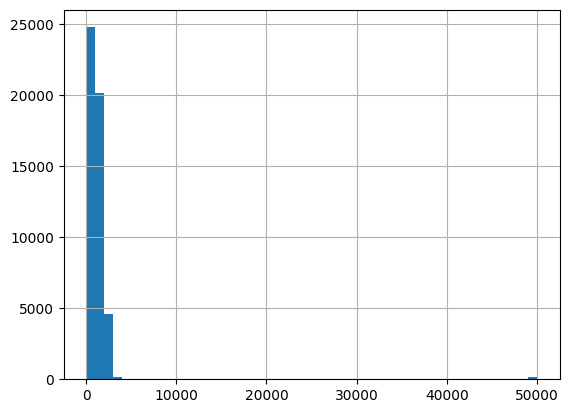

In [10]:
#  Day 2: Synthetic UPI Transactions Dataset Generation

!pip install faker pandas numpy scikit-learn imbalanced-learn xgboost shap optuna matplotlib seaborn --quiet

# --- Step 1: Imports ---
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import datetime, timedelta
import os

# --- Step 2: Ensure folder structure exists ---
os.makedirs("data", exist_ok=True)

# --- Step 3: Initialize Faker and seeds ---
fake = Faker()
Faker.seed(42)
random.seed(42)
np.random.seed(42)

# --- Step 4: Dataset size & fraud ratio ---
TOTAL_TRANSACTIONS = 50000
FRAUD_RATIO = 0.006  # ~0.6% fraud

num_fraud = int(TOTAL_TRANSACTIONS * FRAUD_RATIO)
num_legit = TOTAL_TRANSACTIONS - num_fraud

print(f"Fraud transactions: {num_fraud}, Legit transactions: {num_legit}")

# --- Step 5: Helper functions ---
def random_timestamp():
    start_date = datetime.now() - timedelta(days=90)
    return start_date + timedelta(seconds=random.randint(0, 90*24*60*60))

def device_type():
    return random.choice(["Mobile", "Web", "Tablet"])

def merchant_category():
    return random.choice(["Food", "Shopping", "Bills", "Travel", "Entertainment", "Others"])

def txn_channel():
    return random.choice(["GooglePay", "PhonePe", "Paytm", "BHIM", "AmazonPay"])

def txn_status():
    return random.choice(["Success", "Failed", "Reversed"])

# --- Step 6: Generate LEGIT transactions ---
legit_data = []
for _ in range(num_legit):
    sender_id = fake.uuid4()
    receiver_id = fake.uuid4()
    acc_age = random.randint(100, 2000)
    avg_amount_30d = round(random.uniform(200, 2000), 2)
    amount = max(10, np.random.normal(avg_amount_30d, avg_amount_30d * 0.3))

    legit_data.append([
        fake.uuid4(),
        random_timestamp(),
        round(amount, 2),
        sender_id,
        receiver_id,
        acc_age,
        device_type(),
        fake.city(),
        merchant_category(),
        random.choice([0, 1]),
        txn_channel(),
        txn_status(),
        random.randint(1, 20),
        avg_amount_30d,
        0
    ])

# --- Step 7: Generate FRAUD transactions ---
fraud_data = []
for _ in range(num_fraud):
    sender_id = fake.uuid4()
    receiver_id = fake.uuid4()
    acc_age = random.randint(1, 60)
    avg_amount_30d = round(random.uniform(200, 2000), 2)

    if random.random() < 0.5:
        amount = avg_amount_30d * random.uniform(3, 10)
    else:
        amount = random.choice([49000, 49500, 49999])

    fraud_data.append([
        fake.uuid4(),
        random_timestamp(),
        round(amount, 2),
        sender_id,
        receiver_id,
        acc_age,
        device_type(),
        fake.city(),
        merchant_category(),
        random.choice([0, 1]),
        txn_channel(),
        random.choice(["Success", "Failed"]),
        random.randint(5, 50),
        avg_amount_30d,
        1
    ])

# --- Step 8: Combine & shuffle ---
columns = [
    "transaction_id", "timestamp", "amount", "sender_id_hash", "receiver_id_hash",
    "sender_account_age_days", "device_type", "ip_region", "merchant_category",
    "is_recurring", "txn_channel", "txn_status", "num_prev_txns_24h",
    "avg_amount_30d", "is_fraud"
]

df = pd.DataFrame(legit_data + fraud_data, columns=columns)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# --- Step 9: Save dataset locally ---
df.to_csv("data/synthetic_upi.csv", index=False)
print(f"✅ Dataset created with {df.shape[0]} rows → saved as data/synthetic_upi.csv")

# --- Step 10: Quick EDA ---
print("\nFraud ratio in dataset:")
print(df['is_fraud'].value_counts(normalize=True))
df['amount'].hist(bins=50)


In [12]:
df=pd.read_csv("data/synthetic_upi.csv")
df.head()

,transaction_id,timestamp,amount,sender_id_hash,receiver_id_hash,sender_account_age_days,device_type,ip_region,merchant_category,is_recurring,txn_channel,txn_status,num_prev_txns_24h,avg_amount_30d,is_fraud
0,3c6dacdd-cd38-464f-b153-832753d41db7,2025-07-01 17:21:31.028540,1417.04,a1a780c0-815a-4b76-a0db-2c945f8dce01,9b65cda2-b126-4ed7-82fd-6946a4bb8336,971,Mobile,Jasonburgh,Food,0,BHIM,Reversed,12,1609.81,0
1,980f963f-e889-40d6-b7cf-e3f491af5982,2025-08-05 03:06:57.735839,163.40,a78962ec-9625-4065-9d5b-9a1e1aaf647f,e97167de-fc80-4429-a083-a6768941a444,298,Web,Nealton,Entertainment,0,BHIM,Failed,3,200.18,0
2,0ac4de85-4a5b-4aff-a57f-7595cdfb4db9,2025-06-17 12:00:45.576971,464.70,65001423-faeb-4d19-a550-8ea26133a34d,c5e78b23-f461-4f09-985a-befbd1812f77,1675,Tablet,Stephanieland,Entertainment,1,PhonePe,Success,20,707.19,0
3,38c3a136-fe61-4fb8-a6b0-98fece02c948,2025-06-11 09:36:58.146158,1229.80,dd11827e-4973-42c4-a11a-63b2fc4103e3,146bd244-0597-43bd-9b24-57962cea66d9,796,Mobile,Christinefort,Bills,1,BHIM,Success,6,1915.61,0
4,afd64204-c087-421f-94c5-776f46a853ff,2025-08-08 16:51:15.820740,950.59,0c22862c-a063-45a4-951e-4f0006a169b6,0693fd2c-39df-4918-b381-e74a88479a89,1405,Web,New David,Entertainment,1,Paytm,Reversed,13,695.10,0
